<a href="https://colab.research.google.com/github/Dforouzanfar/Text_Mining_and_Sentiment_Analysis/blob/master/ProjectHateYou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div  align="center">
  <font size='6'>
  Text Mining and Sentiment Analysis
  </font><br>
  <font size='5'>
  Project: I Hate You<br>
  Accademic Year: 2023-2024<br>
  <b>Danial Forouzanfar</b>
  </font>
</div>

# 0. Preliminary Setup

## 0.1. Required Libraries

`contractions` - expands English language contractions (e.g., "don't" to "do not") in text processing tasks.

In [ ]:
!pip install -q contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inflect
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 0.2. Loading a Pretrained Word2Vec Model

In [ ]:
pretrain_wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# 1. Data

In [ ]:
data_path = Path('data')

if not data_path.is_dir():
  data_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "hate_speech.csv", "wb") as f:
  url="https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv"
  request = requests.get(url)
  f.write(request.content)

## 1.1. Data Exploration

In [ ]:
# Read the data
raw_df = pd.read_csv("data/hate_speech.csv")

# Choosing the required columns
raw_df = raw_df[['class', 'tweet']]

# Change the name of each column
raw_df = raw_df.rename(columns={"class": "Label", "tweet": "Text"})

# Remap label values: 0 -> 1, 1 -> 2, and 2 -> 0 to match the desired categorization
mapping = {0: 1, 1: 2, 2: 0}
raw_df["Label"] = raw_df["Label"].replace(mapping)

# Changing the type of labels data
min_sample = raw_df["Label"].value_counts().min()
raw_df = pd.concat([
    raw_df[raw_df["Label"] == label].sample(min_sample, random_state=42)
    for label in raw_df["Label"].unique()
]).reset_index(drop=True)

# Some basic info about the dataset
print(f"Shape of the dataset:\n{raw_df.shape}\n-\nNull Values:\n{raw_df.isna().any()}\n-\nData Types:\n{raw_df.dtypes}\n-\nValue Counts for labels:\n{raw_df['Label'].value_counts()}")

Shape of the dataset:
(4290, 2)
-
Null Values:
Label    False
Text     False
dtype: bool
-
Data Types:
Label     int64
Text     object
dtype: object
-
Value Counts for labels:
Label
0    1430
2    1430
1    1430
Name: count, dtype: int64


<font size='4'>Labels:
<li>0: Neither</li>
<li>1: Hate</li>
<li>2: Offensive</li>
</font>

In [ ]:
# 4 samples of text and their labels
raw_df.sample(n=4)

,Label,Text
2350,2,Money first woman second but you hoes are last !
1700,2,Tanning with my main bitch
3138,1,@young_moniee what's this chinks email? I'm mo...
697,0,RT @kamaalrkhan: Sir @ArvindKejriwal career th...


In [ ]:
raw_df["Text"].loc[2083]

"I actually get on with Erin and think she's really nice bit you're so two faced and bitch about her all the time... #nasty"

In [ ]:
df = raw_df.copy()

# Number of character per text
df["char_count"] = df["Text"].apply(lambda x: len(x))
char_mean = np.mean(df["char_count"])

# Find the indices of the ten rows with the highest values in 'char_count'
indices_to_remove = df['char_count'].nlargest(10).index

# Drop those rows and reset the index
df = df.drop(index=indices_to_remove).reset_index(drop=True)

print(f"Min: {df['char_count'].min()} | Average: {char_mean:<0.3f} | Max: {df['char_count'].max()}")

Min: 5 | Average: 87.514 | Max: 199


In [ ]:
print(f"The text that has the min amount of char: {df['Text'].loc[df['char_count'].idxmin()]}")

The text that has the min amount of char: coons


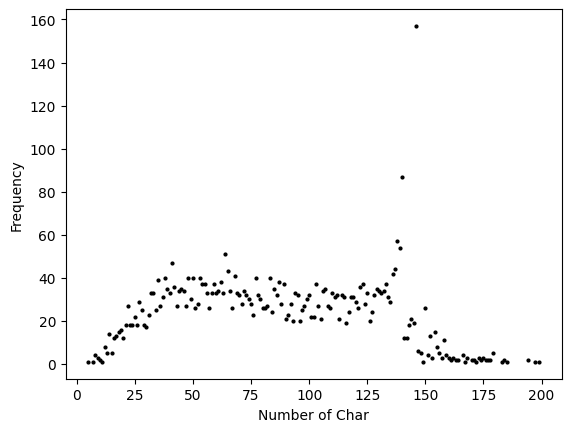

In [ ]:
# Calculate the frequency of each character count and sort by index
char_count = df["char_count"].value_counts().sort_index()

# Create a scatter plot of character counts versus their frequencies
plt.plot(char_count.index, char_count.values, 'o', markersize=2, color='black')
plt.xlabel("Number of Char")
plt.ylabel("Frequency")

plt.show()

In [ ]:
max_freq = char_count.values.max()
char_count = char_count.index[char_count.values == max_freq][0]
print(f"There are {max_freq} texts with a length of {char_count} chars")

There are 157 texts with a length of 146 chars


## 1.2. Data Preparation

In [ ]:
def preprocess_text(text: str,
                    p: inflect.engine,
                    stop_words: set,
                    stemmer: SnowballStemmer) -> list:

  # Convert to lowercase
  text = text.lower()

  # Combined regex pattern for removing hashtags, URLs, and 'rt'
  text = re.sub( r'#\w+|http[s]?://\S+|\brt\b','',text)

  # Replace @mentions with SPECIALTOKEN
  text = re.sub(r'@\w+', '', text)

  # Convert numbers to words
  text = re.sub(r'\d+', lambda digit: p.number_to_words(digit.group()), text)

  # Remove non-alphanumeric chars and newlines
  text = re.sub(r'[^a-zA-Z\s]', '', text).replace('\n', ' ')

  # Remove repeated characters (more than 2 occurrences)
  text = re.sub(r'(.)\1{2,}', r'\1', text)

  # Fix contractions
  text = contractions.fix(text)

  # Clean extra whitespace
  text = ' '.join(text.split())

  # Tokenize
  tokens = word_tokenize(text)

  # Remove stop words and stem in a single pass
  processed_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

  return processed_tokens

def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
  # Initialize all resources once
  p = inflect.engine()
  stop_words = set(stopwords.words('english'))
  stemmer = SnowballStemmer("english")

  # Create copy of relevant columns
  df_pre = df[["Text", "Label"]].copy()

  # Apply all preprocessing steps in a single pass
  df_pre["Text"] = df_pre["Text"].apply(lambda x: preprocess_text(x, p, stop_words, stemmer))

  return df_pre

In [ ]:
# Process your DataFrame
df_processed = process_dataframe(df)

In [ ]:
# Check if we have an empty list
empty_list = df_processed[df_processed["Text"].apply(lambda x: x == [])].shape[0]

if empty_list > 0:
  # Remove rows with empty lists and reset the index
  df_processed = df_processed[df_processed["Text"].apply(lambda x: x != [])].reset_index(drop=True)
  print(f"There were {empty_list} rows with an empty list")

There were 9 rows with an empty list


# 2. Word to Vector

## 2.1. Inspect the Word2Vec Model

In [ ]:
# Access the word vectors
vocab = list(pretrain_wv.index_to_key)  # List of vocabulary words
desired_word = 'king'

# the vector of the desired word
word_vector = pretrain_wv[desired_word]# word2vec_model.wv[desired_word]

# Find similar words
similar_words = pretrain_wv.most_similar(desired_word, topn=9) # word2vec_model.wv.most_similar(desired_word, topn=9)  # Top 9 similar words
print(f"The similar words to {desired_word} are:")

max_length = int(max(len(i) for i,_ in similar_words)) + 1
for i, (j, k) in enumerate(similar_words):
  print(f"{i+1}) {j:<{max_length}}: {k:<0.3f}")

The similar words to king are:
1) kings        : 0.714
2) queen        : 0.651
3) monarch      : 0.641
4) crown_prince : 0.620
5) prince       : 0.616
6) sultan       : 0.586
7) ruler        : 0.580
8) princes      : 0.565
9) Prince_Paras : 0.543


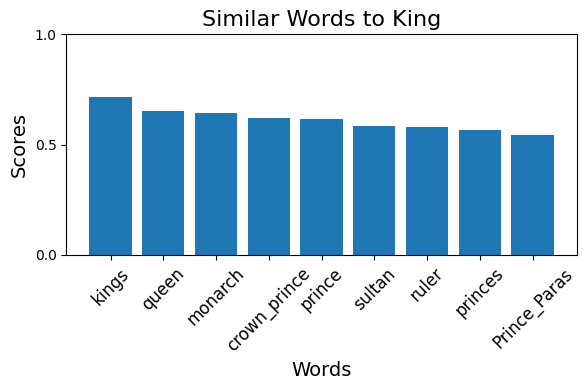

In [ ]:
# Separate data into labels and values
labels, values = zip(*similar_words)

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, values)

# Add titles and labels
plt.title(f'Similar Words to {desired_word.capitalize()}', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(ticks=[0, 0.5, 1])
plt.tight_layout()

# Display the chart
plt.show()

## 2.2. Sentence-Level Vectors

In [ ]:
# Function to compute the average Word2Vec vector for a sentence
def sentence_vector(tokens, model, vector_size):
  vectors = [model[word] for word in tokens if word in model]
  if len(vectors) == 0:
    return np.zeros(vector_size)  # Return a zero vector if no words are found
  return np.mean(vectors, axis=0)

# Apply the function to create sentence-level vectors
vector_size = pretrain_wv.vector_size
df_processed['Word2Vec_Sentence_wv'] = df_processed['Text'].apply(lambda x: sentence_vector(x, pretrain_wv, vector_size))

# 3. Models

In [ ]:
# Prepare the dataset
X = np.array(df_processed['Word2Vec_Sentence_wv'].tolist())
y = df_processed['Label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=36,
                                                    stratify=y)

# Display the shapes of training and testing sets
print(f"Training set: {X_train.shape[0]} | Testing set: {X_test.shape[0]}")

Training set: 2989 | Testing set: 1282


## 3.1. XGBoost

In [ ]:
# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy:<0.2f}\n\nClassification Report:\n{classification_report(y_test, y_pred_xgb)}")

XGBoost Model Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       427
           1       0.72      0.59      0.65       428
           2       0.72      0.73      0.73       427

    accuracy                           0.72      1282
   macro avg       0.72      0.72      0.72      1282
weighted avg       0.72      0.72      0.72      1282




Confusion Matrix:


Text(33.222222222222214, 0.5, 'Truth')

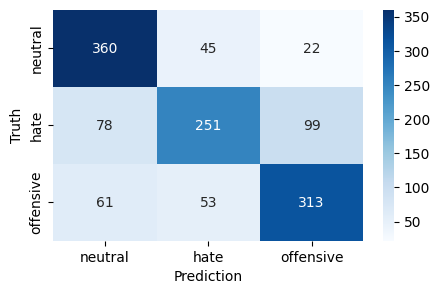

In [ ]:
labels = ['neutral', 'hate', 'offensive']

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize = (5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')

## 3.2. Support Vector Machine

In [ ]:
# Initialize the model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Model Accuracy: {accuracy:<0.2f}\n\nClassification Report:\n{classification_report(y_test, y_pred_svm)}")

Model Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       427
           1       0.69      0.59      0.64       428
           2       0.73      0.70      0.72       427

    accuracy                           0.71      1282
   macro avg       0.71      0.71      0.71      1282
weighted avg       0.71      0.71      0.71      1282




Confusion Matrix:


Text(33.222222222222214, 0.5, 'Truth')

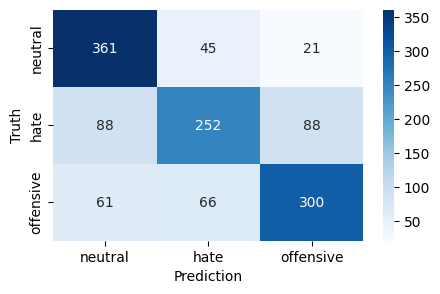

In [ ]:
labels = ['neutral', 'hate', 'offensive']

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize = (5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Truth')